In [1]:
%matplotlib inline

import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Run all output interactively
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

PROJECT_DIR = os.path.dirname(os.getcwd())

In [2]:
wine = pd.read_csv(PROJECT_DIR + '/data/raw/winemag-data-130k-v2.csv', index_col = 0)

In [3]:
wine.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [4]:
wine.describe()

,points,price
count,129971.000000,120975.000000
mean,88.447138,35.363389
std,3.039730,41.022218
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3300.000000


In [5]:
# Extract year from title
## regex to extract date (matching wines from 20th and 21st century)
wine['year'] = wine['title'].apply(lambda x: re.search(r'(19|20)[0-9]{2}', x))  # _sre.SRE_Match object returned
year_exists = ~pd.isnull(wine['year'])  # Find where there is a match 
wine.loc[year_exists, 'year'] = wine.loc[year_exists, 'year'].apply(lambda x: x.group(0))  # extract year where there is a match
wine['year'] = wine['year'].fillna(0)  # For now, just fill missing values with 0
wine['year'] = wine['year'].astype(int)

In [6]:
pd.set_option('display.max_colwidth', 50)
wine['description'].head()

0    Aromas include tropical fruit, broom, brimston...
1    This is ripe and fruity, a wine that is smooth...
2    Tart and snappy, the flavors of lime flesh and...
3    Pineapple rind, lemon pith and orange blossom ...
4    Much like the regular bottling from 2012, this...
Name: description, dtype: object

Determine which columns are numeric and which are categorical

In [7]:
numeric_cols = wine._get_numeric_data().columns
categoric_cols = [c for c in numeric_cols if c not in wine.columns]

In [8]:
wine = wine.dropna(subset = ['points'], axis = 0, how = 'any')

In [9]:
wine['points'].corr(wine['price'])

0.41616674186062252

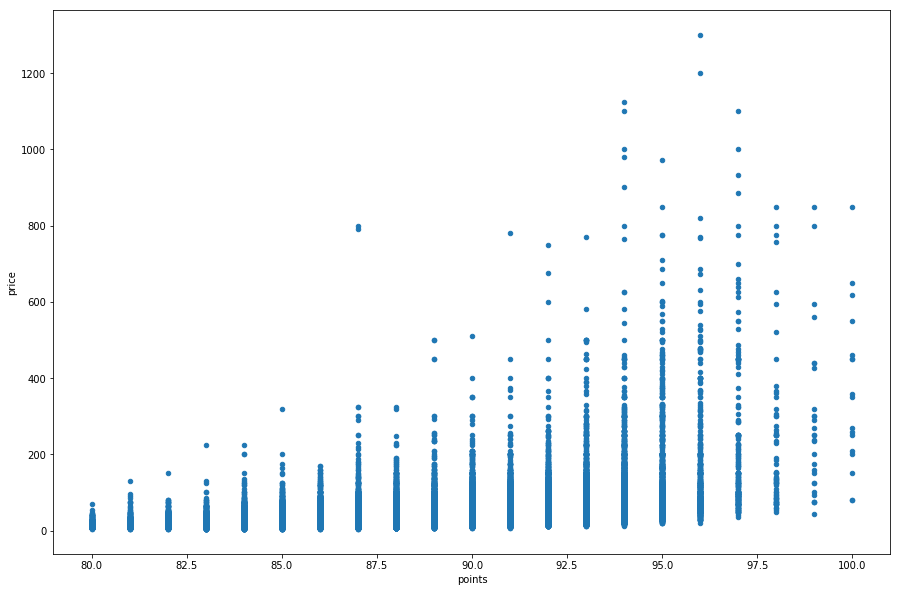

In [10]:
wine = wine.loc[wine['price'] < 1500]
wine.plot.scatter('points', 'price', figsize = (15, 10));

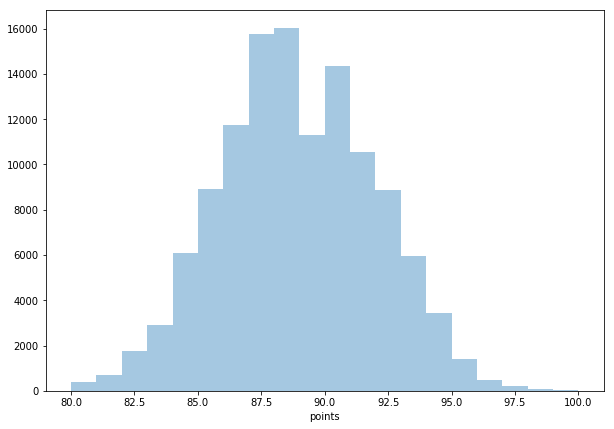

In [11]:
plt.figure(figsize = (10, 7))
sns.distplot(wine['points'], kde = False, bins = 20);

`Price` has many outliers. We can log-transorm it to make it look more akin to a normally-distributed variable, even though it still has a positive skew, due to outliers.

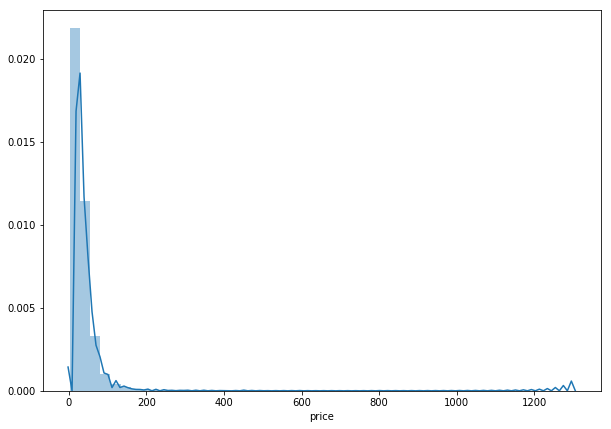

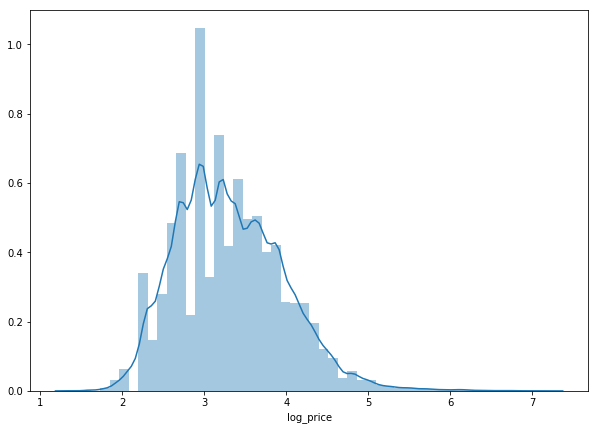

In [12]:
price = wine['price'].dropna()
plt.figure(figsize = (10, 7))
ax = sns.distplot(price)
ax.set_xlabel('price')
plt.show();

log_price = np.log(price)
plt.figure(figsize = (10, 7))
ax = sns.distplot(log_price)
ax.set_xlabel('log_price')
plt.show();

wine['log_price'] = log_price;

The relationship between the `points` has a much higher Pearson's correlation coefficient with the log-transformed `price` than the unadulterated version. But, interestingly, it's very close to Spearman's rank correlation coefficient, which measures the monotonic relationship bewteen the variables.

In [13]:
wine['points'].corr(price)
wine['points'].corr(log_price)
wine['points'].corr(log_price, method = 'spearman')

0.45829672126468129

0.61185277821010209

0.60572121131406531

In [14]:
wine['excellent+'] = np.where(wine['points'] >= 90, 1, 0)

In [15]:
wine.groupby('excellent+').describe()

log_price                                                    \
               count      mean       std       min       25%       50%   
excellent+                                                               
0            75583.0  3.052649  0.532544  1.386294  2.708050  2.995732   
1            45383.0  3.750104  0.600247  1.945910  3.332205  3.688879   

                                 points              ...   price          \
                 75%       max    count       mean   ...     75%     max   
excellent+                                           ...                   
0           3.401197  6.684612  75583.0  86.517960   ...    30.0   800.0   
1           4.094345  7.170120  45383.0  91.591301   ...    60.0  1300.0   

               year                                                        \
              count         mean         std  min     25%     50%     75%   
excellent+                                                                  
0           75583.0  1926.203088  403.301593  0.0  2008.0  2011.0  2013.0   
1           45383.0  1967.631756  291.731258  0.0  2009.0  2012.0  2013.0   

                    
               max  
excellent+          
0           2017.0  
1           2017.0  

[2 rows x 32 columns]

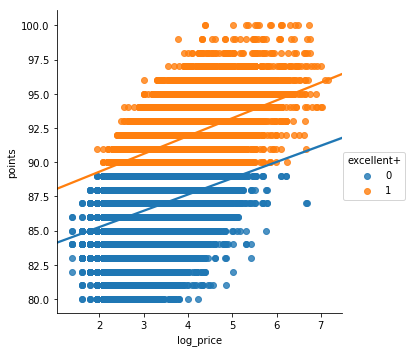

In [16]:
sns.lmplot('log_price', 'points', data = wine, hue = 'excellent+');

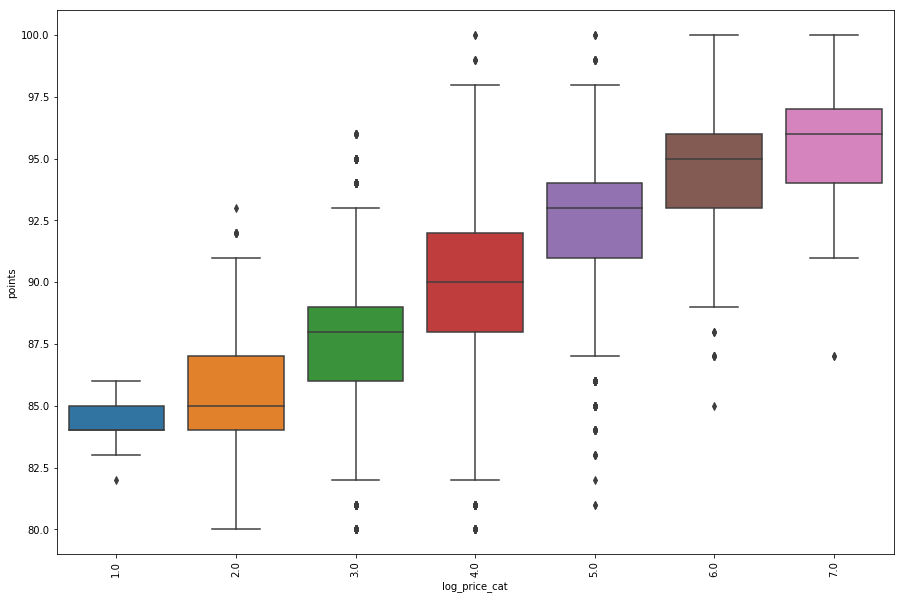

In [17]:
wine['log_price_cat'] = wine['log_price'].round()

fig, ax = plt.subplots(figsize = (15, 10))
sns.boxplot(y = wine['points'], x = wine['log_price_cat'])
plt.xticks(rotation = 90);

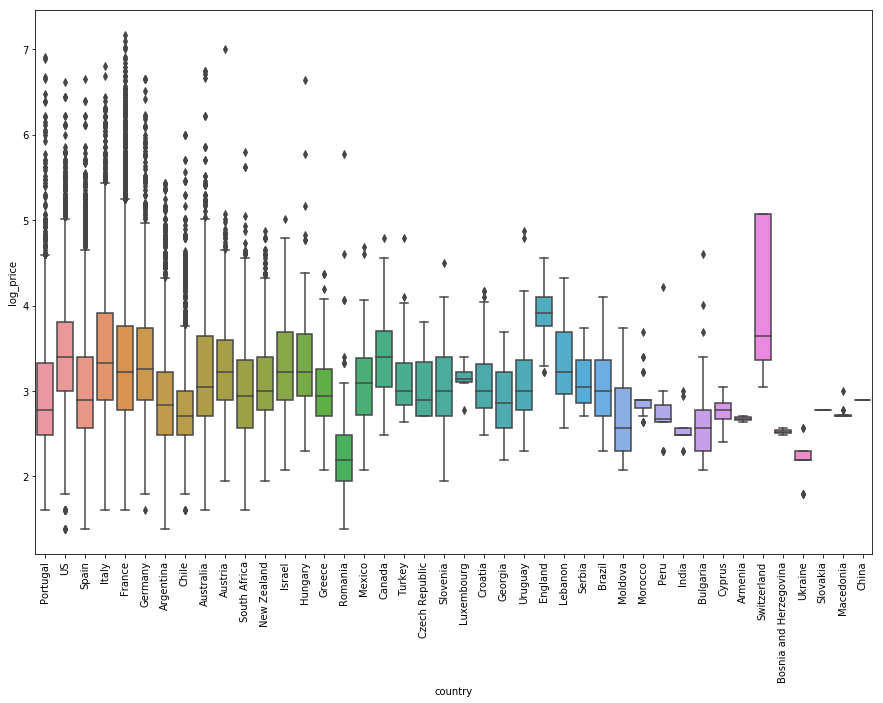

In [18]:
fig, ax = plt.subplots(figsize = (15, 10))
sns.boxplot(y = wine['log_price'], x = wine['country'])
plt.xticks(rotation = 90);

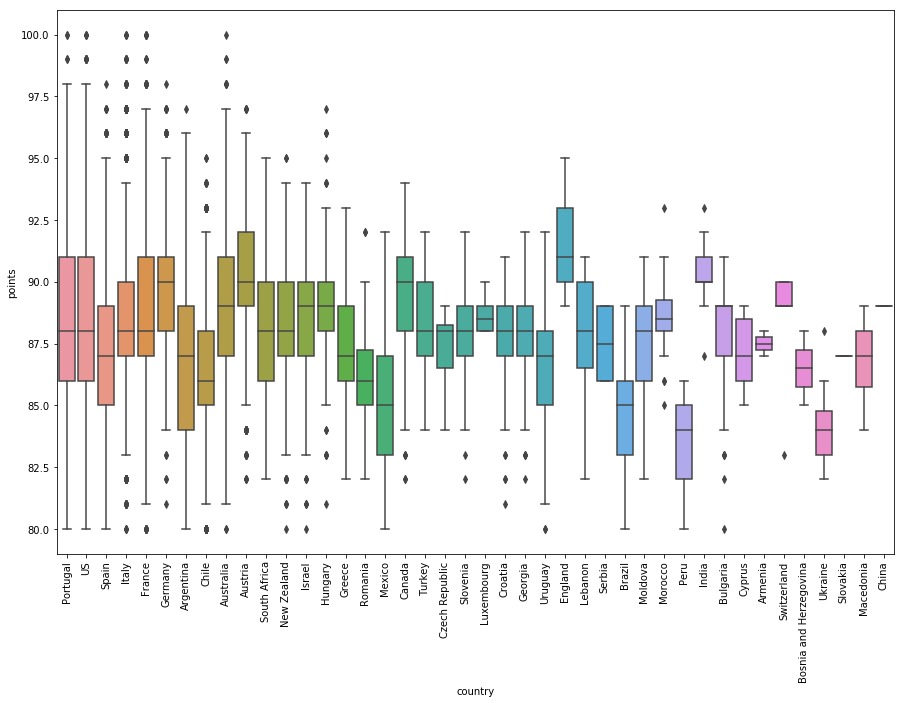

In [19]:
fig, ax = plt.subplots(figsize = (15, 10))
sns.boxplot(y = wine['points'], x = wine['country'])
plt.xticks(rotation = 90);

In [20]:
wine.duplicated(subset = 'title').value_counts()

False    110629
True      10337
dtype: int64

In [21]:
wine = wine.drop_duplicates(subset = 'title')

In [22]:
counts = wine['excellent+'].value_counts()
counts/counts.sum()

0    0.622016
1    0.377984
Name: excellent+, dtype: float64

In [63]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import cross_validation
from sklearn import metrics

In [24]:
wine.columns

Index(['country', 'description', 'designation', 'points', 'price', 'province',
       'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'title',
       'variety', 'winery', 'year', 'log_price', 'excellent+',
       'log_price_cat'],
      dtype='object')

In [25]:
wine['variety'].value_counts().shape
wine['designation'].value_counts().shape

(697,)

(35776,)

In [59]:
data = wine[['excellent+', 'country', 'variety', 'year']]
data = pd.get_dummies(data, columns = ['country', 'variety'])

X = data.drop('excellent+', axis = 1)
y = data['excellent+']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

classifier = LogisticRegressionCV(random_state = 0, cv = 10)

X_train.shape
from sklearn.feature_selection import SelectFromModel
model = SelectFromModel(classifier.fit(X_train, y_train), prefit = True)
X_train_selected = model.transform(X_train)
X_train_selected.shape
X_test_selected = X_test.loc[:, model.get_support()]

# clf = Pipeline([
#   ('feature_selection', SelectFromModel(LogisticRegressionCV(random_state = 0, cv = 10))),
#   ('classification', LogisticRegressionCV())
# ])
# clf.fit(X_train, y_train)
classifier = LogisticRegression(random_state = 0)
y_pred = cross_val_predict(classifier, X_test_selected, y_test, cv = 10)
y_pred_probs = cross_val_predict(classifier, X_test_selected, y_test, cv = 10, method='predict_proba')

print(confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.roc_auc_score(y_test, y_pred_probs[:, 1]))


(82971, 740)

(82971, 112)

In [78]:
data = wine[['excellent+', 'log_price', 'country', 'variety', 'year']]
data = pd.get_dummies(data, columns = ['country', 'variety'])

X = data.drop('excellent+', axis = 1)
y = data['excellent+']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

classifier = LogisticRegression(random_state = 0)
y_pred = cross_val_predict(classifier, X_train, y_train, cv = 10)
y_pred_probs = cross_val_predict(classifier, X_train, y_train, cv = 10, method='predict_proba')

print(confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.roc_auc_score(y_test, y_pred_probs[:, 1]))

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
y_pred_probs = classifier.predict_proba(X_test)

print(confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.roc_auc_score(y_test, y_pred_probs[:, 1]))


ValueError: Found input variables with inconsistent numbers of samples: [27658, 82971]

In [224]:
model = classifier.fit(X_train, y_train)
exp_coef = pd.DataFrame({'exp_coef': np.exp(model.coef_[0])}, index = X.columns).sort_values('exp_coef', ascending = 0)
exp_coef.head(10)          
exp_coef.tail(10) 

,exp_coef
variety_Nebbiolo,4.125112
country_Austria,3.033300
variety_Syrah,2.388309
variety_Sangiovese Grosso,2.266677
variety_Pinot Noir,2.065985
variety_Champagne Blend,1.985144
country_Germany,1.771638
variety_Port,1.720433
variety_Portuguese Red,1.465972
variety_Cabernet Sauvignon,1.462979


,exp_coef
variety_Bordeaux-style White Blend,0.694869
country_South Africa,0.692128
variety_Sauvignon Blanc,0.655407
variety_White Blend,0.565839
variety_Merlot,0.564358
variety_Portuguese White,0.538446
variety_Pinot Grigio,0.394791
country_Argentina,0.393710
variety_Rosé,0.325227
country_Chile,0.258605


In [ ]:
data2 = wine[['excellent+', 'log_price']]

X2 = data2.drop('excellent+', axis = 1)
y = data2['excellent+']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

classifier = LogisticRegression(random_state = 0)
y_pred2 = cross_val_predict(classifier, X2, y, cv = 10)
y_pred_probs2 = cross_val_predict(classifier, X2, y, cv = 10, method='predict_proba')
classifier.fit(X_train, y_train)
# y_pred_probs = classifier.predict(X_test)

print(confusion_matrix(y, y_pred2))
print(metrics.classification_report(y, y_pred2))
print(metrics.accuracy_score(y, y_pred2))
print(metrics.roc_auc_score(y, y_pred_probs2[:, 1]))

In [ ]:
from xgboost.sklearn import XGBClassifier

xgb_clas = XGBClassifier()
xgb_clas.fit(X_train, y_train)

In [225]:
y_pred_xgb = cross_val_predict(xgb_clas, X_train, y_train, cv = 2)

In [226]:
print(confusion_matrix(y_train, y_pred_xgb))
print(metrics.classification_report(y_train, y_pred_xgb))
print(metrics.accuracy_score(y_train, y_pred_xgb))

[[47986  3585]
 [24533  6867]]
             precision    recall  f1-score   support

          0       0.66      0.93      0.77     51571
          1       0.66      0.22      0.33     31400

avg / total       0.66      0.66      0.60     82971

0.661110508491


In [227]:
y_pred_probs_xgb = cross_val_predict(xgb_clas, X_train, y_train, cv = 2, method='predict_proba')
print(metrics.roc_auc_score(y_train, y_pred_probs_xgb[:, 1]))

0.684313146232
